# 15.1 Multi-objective least squares

Write a function taht solves the multi objective least squares problem, with given positive weights.

**The data are:**
- a vector of coefficient matrices **As** ($ A_1,... ,A_k $)
- a matching vector of (right hand side) vectors **bs** ($ b_1,... ,b_k $),
- and the **weights** given as an vector **lambdas**($\lambda_1,..., \lambda_k$).

Stack $A_1,...,A_k$ into $\tilde{A}$, then solve  $\tilde{A}x = \tilde{b}$

In [13]:
using LinearAlgebra
using VMLS 
function mols_solve(As, bs, lambdas)
    k = length(lambdas)
    Atil = vcat( [ sqrt(lambdas[i]) * As[i] for i=1:k ]... )
    btil = vcat( [ sqrt(lambdas[i]) * bs[i] for i=1:k ]... )
    xhat = Atil \ btil 
    return xhat
end

mols_solve (generic function with 1 method)

Use function **mols_solve** to work out a bi criterion example

We minimize the weighted sum objective 

\begin{align}

J_1 + \lambda * J_2 = ||A_1x-b_1||^2 + \lambda ||A_2x-b_2||^2

\end{align}

- for randomly chosen 10x5 matrices A1, A2 and 10-vectors b1, b2.
- **lambdas** = $ [\lambda_1, ..., \lambda_{200}], \lambda \in [10^{-4},10^4] $

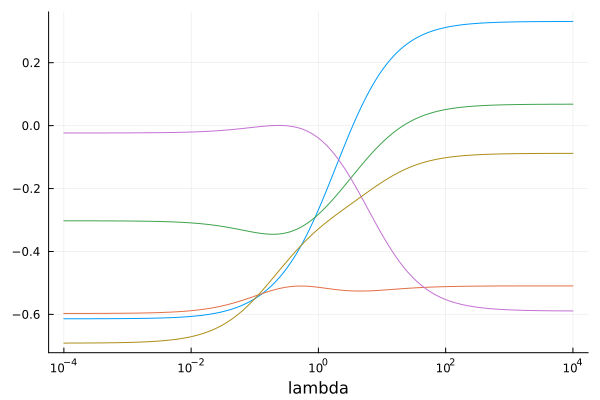

In [18]:
A1 = randn(10, 5)
A2 = randn(10, 5)
As = [A1, A2]

b1 = randn(10)
b2 = randn(10)
bs = [b1, b2]

N = 200
lambdas = 10 .^ linspace(-4, 4, N)
x = zeros(5, N)
J1 = zeros(N)
J2 = zeros(N)

for k=1:N 
    xhat = mols_solve(As, bs, [1 lambdas[k]])
    x[:, k] = xhat 
    J1[k] = norm(As[1]*xhat-bs[1])^2
    J2[k] = norm(As[2]*xhat-bs[2])^2
end

using Plots
plot(lambdas, x', xscale = :log10, xlabel="lambda", label="")